<a href="https://colab.research.google.com/github/tri22/ATBMCK/blob/main/research/training_models.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Dự đoán nguy cơ mắc bệnh tim

Notebook này trình bày toàn bộ quy trình xử lý dữ liệu, xây dựng và so sánh các mô hình (MLP, Random Forest, XGBoost, SVM) nhằm dự đoán khả năng mắc bệnh tim dựa trên các chỉ số lâm sàng.


## Quy trình tổng quát
- Khảo sát dữ liệu, kiểm tra thiếu và ngoại lệ
- Làm sạch, chuẩn hóa và chọn đặc trưng
- Chia dữ liệu train/test (stratify theo nhãn)
- Huấn luyện MLP (Keras Sequential) và các mô hình so sánh: Random Forest, XGBoost, SVM
- Đánh giá Accuracy, Precision, Recall, F1, Specificity, AUC-ROC


## Association Rules với Apriori Algorithm

Phân tích luật kết hợp để tìm các mẫu và mối quan hệ giữa các đặc trưng trong dữ liệu bệnh tim.


   age  sex  cp  trestbps  chol  fbs  restecg  thalach  exang  oldpeak  slope  \
0   52    1   0       125   212    0        1      168      0      1.0      2   
1   53    1   0       140   203    1        0      155      1      3.1      0   
2   70    1   0       145   174    0        1      125      1      2.6      0   
3   61    1   0       148   203    0        1      161      0      0.0      2   
4   62    0   0       138   294    1        1      106      0      1.9      1   

   ca  thal  target  
0   2     3       0  
1   0     3       0  
2   0     3       0  
3   1     3       0  
4   3     2       0  
               age          sex           cp     trestbps        chol  \
count  1025.000000  1025.000000  1025.000000  1025.000000  1025.00000   
mean     54.434146     0.695610     0.942439   131.611707   246.00000   
std       9.072290     0.460373     1.029641    17.516718    51.59251   
min      29.000000     0.000000     0.000000    94.000000   126.00000   
25%      48.0000

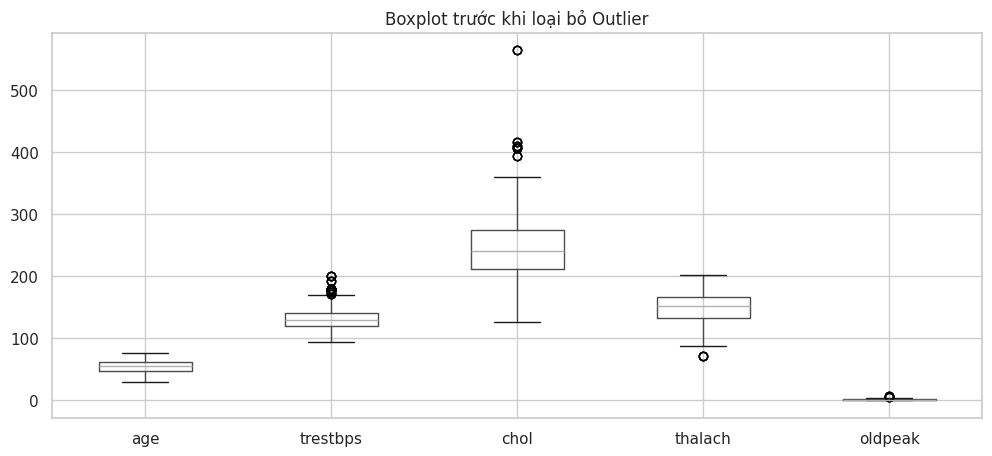

   - Cột 'trestbps': Loại bỏ 30 outliers.
   - Cột 'chol': Loại bỏ 16 outliers.
   - Cột 'thalach': Loại bỏ 4 outliers.
   - Cột 'oldpeak': Loại bỏ 11 outliers.
-> Đã loại bỏ tổng cộng 61 dòng nhiễu.
-> Kích thước dữ liệu sạch: (964, 14)


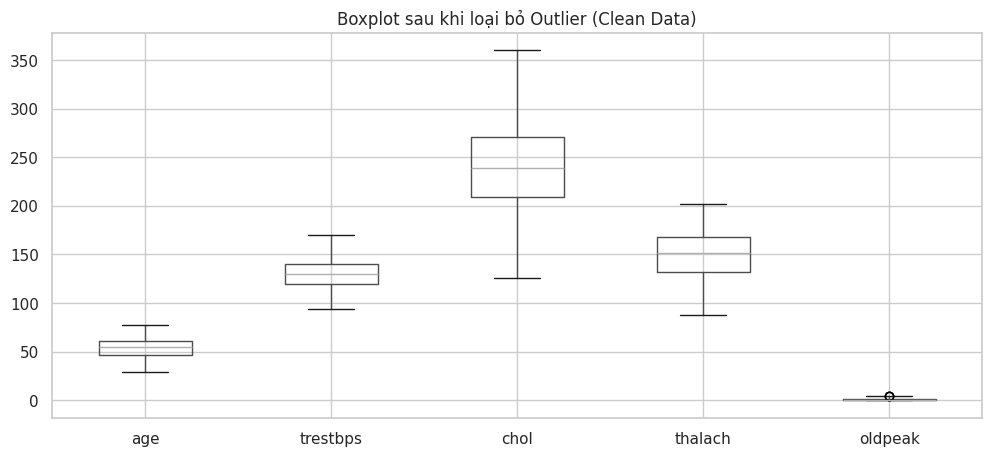

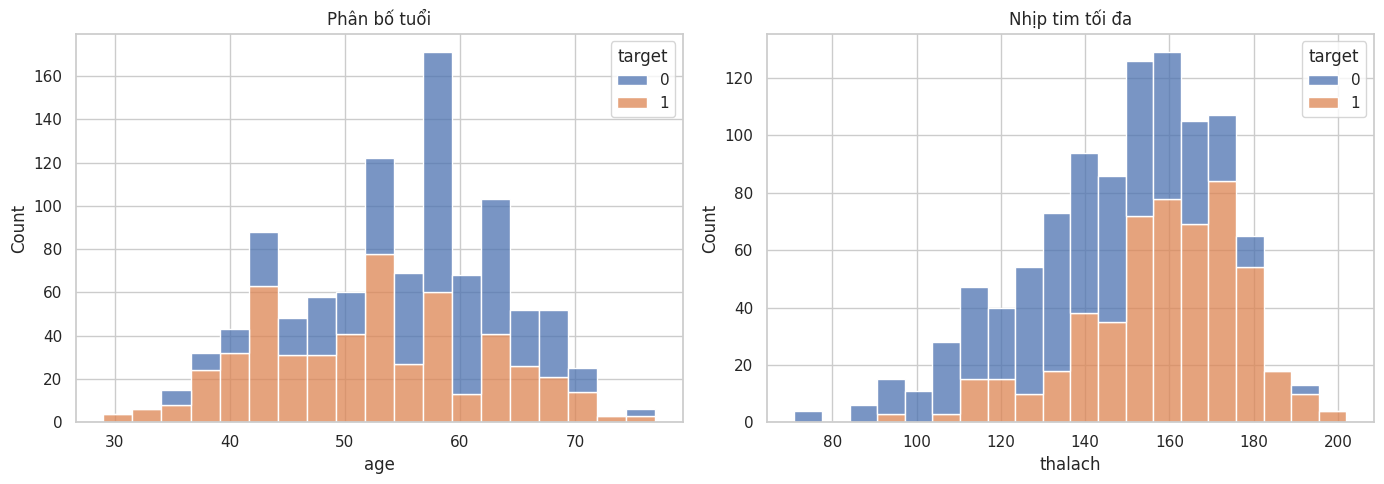

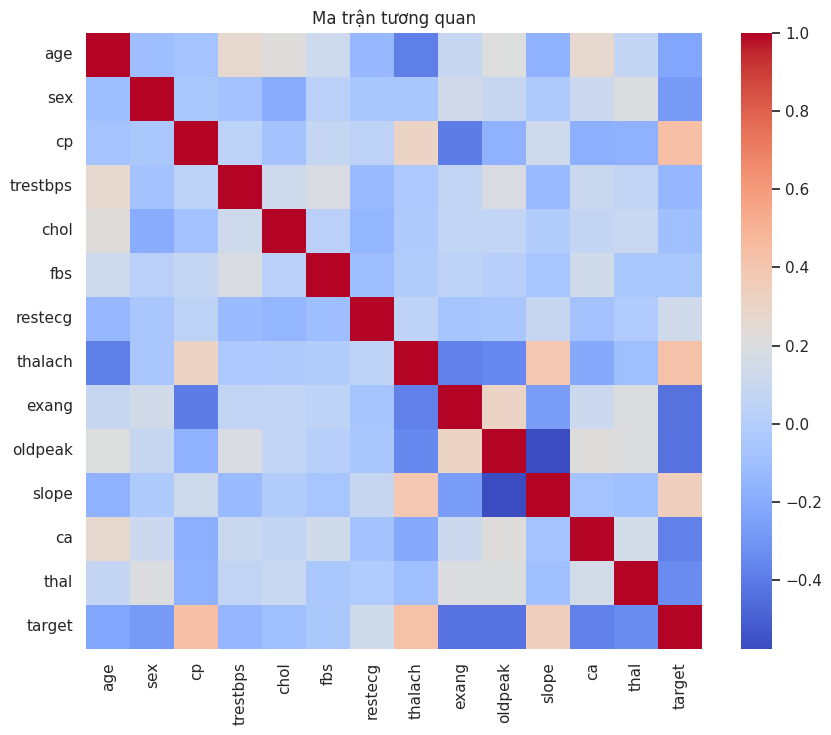

Train/Test: (674, 13) (290, 13)
FEATURES CUỐI CÙNG DÙNG CHO MODEL: ['age', 'cp', 'trestbps', 'chol', 'thalach', 'exang', 'oldpeak', 'slope', 'ca', 'thal']
MLP TỐI ƯU hyperparameters: {'num_layers': 2, 'units_0': 96, 'dropout': 0.1, 'learning_rate': 0.0075100970974425725, 'units_1': 64, 'units_2': 64, 'tuner/epochs': 30, 'tuner/initial_epoch': 10, 'tuner/bracket': 2, 'tuner/round': 2, 'tuner/trial_id': '0067'}
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
SVM TỐI ƯU: {'C': 10, 'gamma': 0.1}
XGBoost TỐI ƯU: {'learning_rate': 0.05, 'max_depth': 5, 'n_estimators': 200}
         model  accuracy  precision    recall        f1  specificity       auc
2      XGBoost  0.979310   1.000000  0.960784  0.980000     1.000000  0.993559
1    SVM (RBF)  0.955172   0.972973  0.941176  0.956811     0.970803  0.973331
0  MLP (Keras)  0.882759   0.916084  0.856209  0.885135     0.912409  0.951624


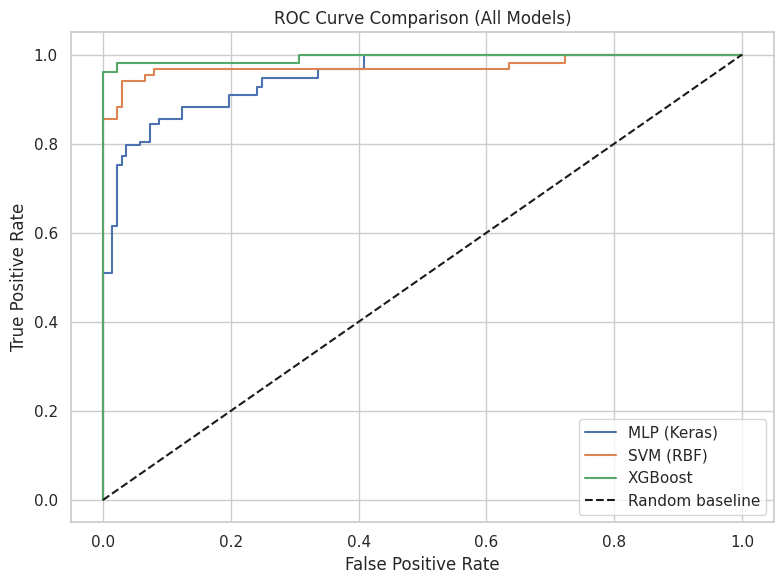

Đã lưu scaler.pkl và selector.pkl
Đã lưu xgb_model.json
Đã lưu mlp_model.h5
Đã lưu svm_model.pkl


In [ ]:
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from pathlib import Path
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.feature_selection import SelectKBest, mutual_info_classif

from sklearn.metrics import (
    accuracy_score, precision_score, recall_score,
    f1_score, confusion_matrix, roc_auc_score, roc_curve
)

from sklearn.svm import SVC
import xgboost as xgb

import tensorflow as tf
from tensorflow import keras

!pip install -q keras-tuner

import kerastuner as kt

sns.set_theme(style="whitegrid")
RANDOM_STATE = 42

# ============================
# 1. Load dữ liệu
# ============================

DATA_PATH = Path("heart.csv")
raw_df = pd.read_csv(DATA_PATH)

print(raw_df.head())
print(raw_df.describe())
print(raw_df.isna().sum())

# ============================
# Xử lý Outlier (IQR Method)
# ============================

# Chỉ lọc trên các biến liên tục quan trọng
continuous_cols = ['age', 'trestbps', 'chol', 'thalach', 'oldpeak']

df = raw_df.copy()

# Boxplot trước khi xử lý để so sánh

plt.figure(figsize=(12, 5))
raw_df[continuous_cols].boxplot()
plt.title("Boxplot trước khi loại bỏ Outlier")
plt.show()

old_rows = df.shape[0]

for col in continuous_cols:
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1

    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    # Đếm số lượng outlier sẽ bị loại
    outliers_count = ((df[col] < lower_bound) | (df[col] > upper_bound)).sum()
    if outliers_count > 0:
        print(f"   - Cột '{col}': Loại bỏ {outliers_count} outliers.")

    # Lọc dữ liệu
    df = df[(df[col] >= lower_bound) & (df[col] <= upper_bound)]

print(f"-> Đã loại bỏ tổng cộng {old_rows - df.shape[0]} dòng nhiễu.")
print(f"-> Kích thước dữ liệu sạch: {df.shape}")

# Boxplot sau khi xử lý
plt.figure(figsize=(12, 5))
df[continuous_cols].boxplot()
plt.title("Boxplot sau khi loại bỏ Outlier (Clean Data)")
plt.show()

# ============================
# 2. EDA nhanh (Optional)
# ============================

fig, axes = plt.subplots(1, 2, figsize=(14, 5))
sns.histplot(data=raw_df, x="age", hue="target", multiple="stack", ax=axes[0])
sns.histplot(data=raw_df, x="thalach", hue="target", multiple="stack", ax=axes[1])
axes[0].set_title("Phân bố tuổi")
axes[1].set_title("Nhịp tim tối đa")
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 8))
sns.heatmap(raw_df.corr(numeric_only=True), cmap="coolwarm", square=True)
plt.title("Ma trận tương quan")
plt.show()

# ============================
# 3. Train/Test split
# ============================

X = df.drop(columns="target")
y = df["target"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=RANDOM_STATE, stratify=y
)

print("Train/Test:", X_train.shape, X_test.shape)

# ============================
# 4. Scale + Feature Selection (CHUẨN QUY TRÌNH)
# ============================

scaler = StandardScaler()
selector = SelectKBest(mutual_info_classif, k=min(10, X_train.shape[1]))

# Scale data
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled  = scaler.transform(X_test)

# Select features
selector.fit(X_train_scaled, y_train)

X_train_selected = selector.transform(X_train_scaled)
X_test_selected  = selector.transform(X_test_scaled)

selected_features = X_train.columns[selector.get_support()]
print("FEATURES CUỐI CÙNG DÙNG CHO MODEL:", list(selected_features))

# ============================
# 5. Hàm đánh giá
# ============================

def evaluate_model(name, y_true, y_prob, threshold=0.5):
    y_pred = (y_prob >= threshold).astype(int)
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    specificity = tn / (tn + fp)

    return {
        "model": name,
        "accuracy": accuracy_score(y_true, y_pred),
        "precision": precision_score(y_true, y_pred, zero_division=0),
        "recall": recall_score(y_true, y_pred, zero_division=0),
        "f1": f1_score(y_true, y_pred, zero_division=0),
        "specificity": specificity,
        "auc": roc_auc_score(y_true, y_prob)
    }

results = []
roc_curves = {}

# ============================
# 6. Model 1 – MLP Keras + KERAS TUNER
# ============================

def build_mlp_model(hp):
    model = keras.Sequential()
    model.add(keras.layers.Input(shape=(X_train_selected.shape[1],)))

    for i in range(hp.Int('num_layers', 1, 3)):  # giảm từ 4 xuống 3
        model.add(keras.layers.Dense(
            units=hp.Int(f'units_{i}', min_value=32, max_value=96, step=32),  # giảm max units
            activation='relu'
        ))
        model.add(keras.layers.Dropout(hp.Float('dropout', 0.1, 0.4, step=0.1)))

    model.add(keras.layers.Dense(1, activation='sigmoid'))

    model.compile(
        optimizer=keras.optimizers.Adam(hp.Float('learning_rate', 1e-3, 1e-2, sampling='log')),
        loss='binary_crossentropy',
        metrics=['accuracy']
    )
    return model

tuner = kt.Hyperband(
    build_mlp_model,
    objective='val_accuracy',
    max_epochs=30,  # giảm mạnh từ 100 xuống 30
    factor=3,
    directory='mlp_tuner',
    project_name='heart_disease',
    overwrite=True
)

early_stop = keras.callbacks.EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True)

tuner.search(X_train_selected, y_train, epochs=30, validation_split=0.2, callbacks=[early_stop], verbose=0)

best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
print("MLP TỐI ƯU hyperparameters:", best_hps.values)

mlp = tuner.hypermodel.build(best_hps)
mlp.fit(X_train_selected, y_train, epochs=100, batch_size=32, validation_split=0.2, callbacks=[early_stop], verbose=0)

mlp_probs = mlp.predict(X_test_selected).ravel()
results.append(evaluate_model("MLP (Keras)", y_test.values, mlp_probs))
roc_curves["MLP (Keras)"] = roc_curve(y_test, mlp_probs)
# ============================
# 7. Model 2 – SVM + GridSearchCV
# ============================

svm_params = {
    "C": [1, 10, 100],
    "gamma": ["scale", 0.01, 0.1],
}

svm_grid = GridSearchCV(
    SVC(kernel="rbf", probability=True, class_weight='balanced', random_state=RANDOM_STATE),
    svm_params,
    cv=3,
    scoring="roc_auc",
    n_jobs=-1
)

svm_grid.fit(X_train_selected, y_train)
print("SVM TỐI ƯU:", svm_grid.best_params_)

svm = svm_grid.best_estimator_
svm_probs = svm.predict_proba(X_test_selected)[:, 1]
results.append(evaluate_model("SVM (RBF)", y_test.values, svm_probs))
roc_curves["SVM (RBF)"] = roc_curve(y_test, svm_probs)
# ============================
# 8. Model 3 – XGBoost
# ============================

xgb_params = {
    "n_estimators": [100, 200],
    "learning_rate": [0.05, 0.1],
    "max_depth": [3, 5],
}

xgb_grid = GridSearchCV(
    xgb.XGBClassifier(eval_metric="logloss", random_state=RANDOM_STATE),
    xgb_params,
    cv=3,
    scoring="roc_auc",
    n_jobs=-1
)

xgb_grid.fit(X_train_selected, y_train)
print("XGBoost TỐI ƯU:", xgb_grid.best_params_)

xgb_model = xgb_grid.best_estimator_
xgb_probs = xgb_model.predict_proba(X_test_selected)[:, 1]
results.append(evaluate_model("XGBoost", y_test.values, xgb_probs))
roc_curves["XGBoost"] = roc_curve(y_test, xgb_probs)

# ============================
# 9. Bảng kết quả
# ============================

results_df = pd.DataFrame(results).sort_values(by="auc", ascending=False)
print(results_df)

# ============================
# 10. Vẽ ROC
# ============================

plt.figure(figsize=(8, 6))

for name, (fpr, tpr, _) in roc_curves.items():
    plt.plot(fpr, tpr, label=name)

plt.plot([0, 1], [0, 1], "k--", label="Random baseline")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve Comparison (All Models)")
plt.legend()
plt.tight_layout()
plt.show()

# ============================
# 11. Lưu models & preprocess objects
# ============================

import joblib
import os

MODELS_DIR = Path("../backend/app/models")
MODELS_DIR.mkdir(parents=True, exist_ok=True)

joblib.dump(scaler, MODELS_DIR / "scaler.pkl")
joblib.dump(selector, MODELS_DIR / "selector.pkl")
print("Đã lưu scaler.pkl và selector.pkl")

xgb_model.save_model(str(MODELS_DIR / "xgb_model.json"))
print("Đã lưu xgb_model.json")

mlp.save(str(MODELS_DIR / "mlp_model.h5"))
print("Đã lưu mlp_model.h5")

joblib.dump(svm, MODELS_DIR / "svm_model.pkl")
print("Đã lưu svm_model.pkl")
